<h1><center>Exploratory Data Analysis</center></h1>

This notebook contains analysis of the data. During this analysis description of each column in the data will be provided along with ideas how to preprocess it. 

In [1]:
import os
import warnings
from collections import Counter

import numpy as np
import pandas as pd
import seaborn as sns
from bertopic import BERTopic
from bs4 import BeautifulSoup
from Levenshtein import ratio
from matplotlib import pyplot as plt
from umap import UMAP

from src import config

pd.set_option("display.max_colwidth", 100)

warnings.simplefilter(action="ignore", category=FutureWarning)


In [2]:
# root folder of the project
ROOT = os.path.realpath("../")


# 1. Read data

Read data from csv file and display the first article.

In [3]:
data = pd.read_csv(os.path.join(ROOT, config.data.path.raw))
data.head(1)


,title,url,published_at,author,publisher,short_description,keywords,header_image,raw_description,description,scraped_at
0,Santoli’s Wednesday market notes: Could September’s stock shakeout tee up strength for the fourt...,https://www.cnbc.com/2021/09/29/santolis-wednesday-market-notes-could-septembers-stock-shakeout-...,2021-09-29T17:09:39+0000,Michael Santoli,CNBC,"This is the daily notebook of Mike Santoli, CNBC's senior markets commentator, with ideas about ...","cnbc, Premium, Articles, Investment strategy, Markets, Investing, PRO Home, CNBC Pro, Pro: Santo...",https://image.cnbcfm.com/api/v1/image/106949602-1632934577499-FINTECH_ETF_9-29.jpg?v=1632934691,"<div class=""group""><p><em>This is the daily notebook of Mike Santoli, CNBC's senior markets comm...","This is the daily notebook of Mike Santoli, CNBC's senior markets commentator, with ideas about ...",2021-10-30 14:11:23.709372


In [4]:
# data rows
print(data.shape)


(625, 11)


Dataset contains 625 article and each article has 11 values (columns).

In [5]:
data.columns.tolist()


['title',
 'url',
 'published_at',
 'author',
 'publisher',
 'short_description',
 'keywords',
 'header_image',
 'raw_description',
 'description',
 'scraped_at']

Article values:
1. **title**: title of article, how it's named on CNBC website
2. **url**: url of article, should contain cnbc.com domain (as it's dataset with articles from CNBC)
3. **published_at**: when article was published on CNBC website
4. **author**: name of the article's author/authors
5. **publisher**: name of the publisher, should be CNBC
6. **short_description**: shortened version of description (article body), handy when quickly observing articles
7. **keyword**: list of keywords, helps find articles of the same topic
8. **header_image**: link to the image with which the article was posted
9. **raw_description**: article's body without any post-processing. Description is the same as raw_description only without html tags
10. **description**: article's body without html tags
11. **scraped_at**: when article was scraped from cnbc.com

Now it's a good idea to check how many missing values per each column we have:

In [6]:
nan_values_df = data.isna().sum().reset_index().rename(columns={"index": "Columns", 0: "Num of NaN"})
nan_values_df["%"] = nan_values_df["Num of NaN"].apply(lambda x: int(x / len(data) * 100))
nan_values_df


,Columns,Num of NaN,%
0,title,0,0
1,url,0,0
2,published_at,0,0
3,author,228,36
4,publisher,0,0
5,short_description,16,2
6,keywords,0,0
7,header_image,0,0
8,raw_description,31,4
9,description,32,5


One third of all articles have missing author and small fraction of all variants of descriptions are missing. Interestingly enough short_description has less missing values than description or raw_description.

Now let's take a look at how many rows have only one missing value, two missing values, ... all values are missing,

In [7]:
na_count = data.isna().sum(axis=1).tolist()
nan_values_df = pd.DataFrame(columns=["NaN per row", "Number of rows", "%"])

for idx in range(data.shape[-1]):
    nan_count = na_count.count(idx)
    nan_values_df.loc[idx] = idx, nan_count, int(nan_count / len(data) * 100)

nan_values_df.style.hide_index()


NaN per row,Number of rows,%
0,376,60
1,207,33
2,27,4
3,14,2
4,1,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


As we can see more than half of the dataset doesn't not have any missing value, one third of articles have one missing value and no articles have all missing values.

## 1.1. EDA structure

Now, having initial observations above here is planned structure of the analysis:

| Column | Planned analysis |
| --- | --- |
| **title** | min/max/average length, show the most popular topics |
| **url** | what site is the most popular |
| **published_date** | min/max range, show distribution per year, season/year |
| **author** | show how many authors there are on average per each article, who is the most popular author |
| **publisher** | check that there is only one publisher |
| **short_description** | check that short_description is just a beginning of description; if it is so then in case short_description is missing it can be replaced by the beginning of description |
| **keywords** | how many keywords there are on average, what is the most popular, what is the list popular |
| **header_image** | check that all images are located on cnbc website |
| **raw_description** | check that it is the same as description only with html tags. In case raw description exists but not description, raw description can be used as description but only after stripping all html tags |
| **description** | min/average/max len of description |
| **scraped_at** | check when this dataset was scraped |


# 2. Describing each column

## 2.1. Title

In [8]:
data.loc[:3, "title"]


0    Santoli’s Wednesday market notes: Could September’s stock shakeout tee up strength for the fourt...
1                                                         My take on the early Brexit winners and losers
2                                                   Europe&#039;s recovery depends on Renzi&#039;s Italy
3                                                  US Moves Closer to Becoming A Major Shareholder In GM
Name: title, dtype: object

Title represented as a text.

In [9]:
data["title"].isna().sum()


0

There are no missing values for "title" column.

### 2.1.1. Removing special characters

In [10]:
title_text = data.loc[2, "title"]
title_text


'Europe&#039;s recovery depends on Renzi&#039;s Italy'

As we can see some titles may contain specially encoded characters. Let's try to convert these characters with BeautifulSoup:

In [11]:
BeautifulSoup(title_text).text


"Europe's recovery depends on Renzi's Italy"

In [12]:
titles_converted = data["title"].apply(lambda x: BeautifulSoup(x).text.strip())
titles_original = data["title"].str.strip()
titles_with_special_chars = titles_converted != titles_original
print(f"Number of articles with titles containing special characters: {titles_with_special_chars.sum()}")
pd.DataFrame(
    zip(*[titles_original[titles_with_special_chars], titles_converted[titles_with_special_chars]]),
    columns=["title_original", "title_converted"],
)


Number of articles with titles containing special characters: 4


,title_original,title_converted
0,Europe&#039;s recovery depends on Renzi&#039;s Italy,Europe's recovery depends on Renzi's Italy
1,Why Trump&rsquo;s rigged-election claim is likely to backfire,Why Trump’s rigged-election claim is likely to backfire
2,"Commodities Help Bring New Lows For NASDAQ, S&P","Commodities Help Bring New Lows For NASDAQ, SP"
3,How to nail a pitch to a &lsquo;Shark&rsquo;,How to nail a pitch to a ‘Shark’


<div class="alert alert-block alert-info"><b>Preprocessing idea</b>: Convert special characters and strip empty characters in the beginning and the end of the title.</div>


### 2.1.2. Characters and words distribution

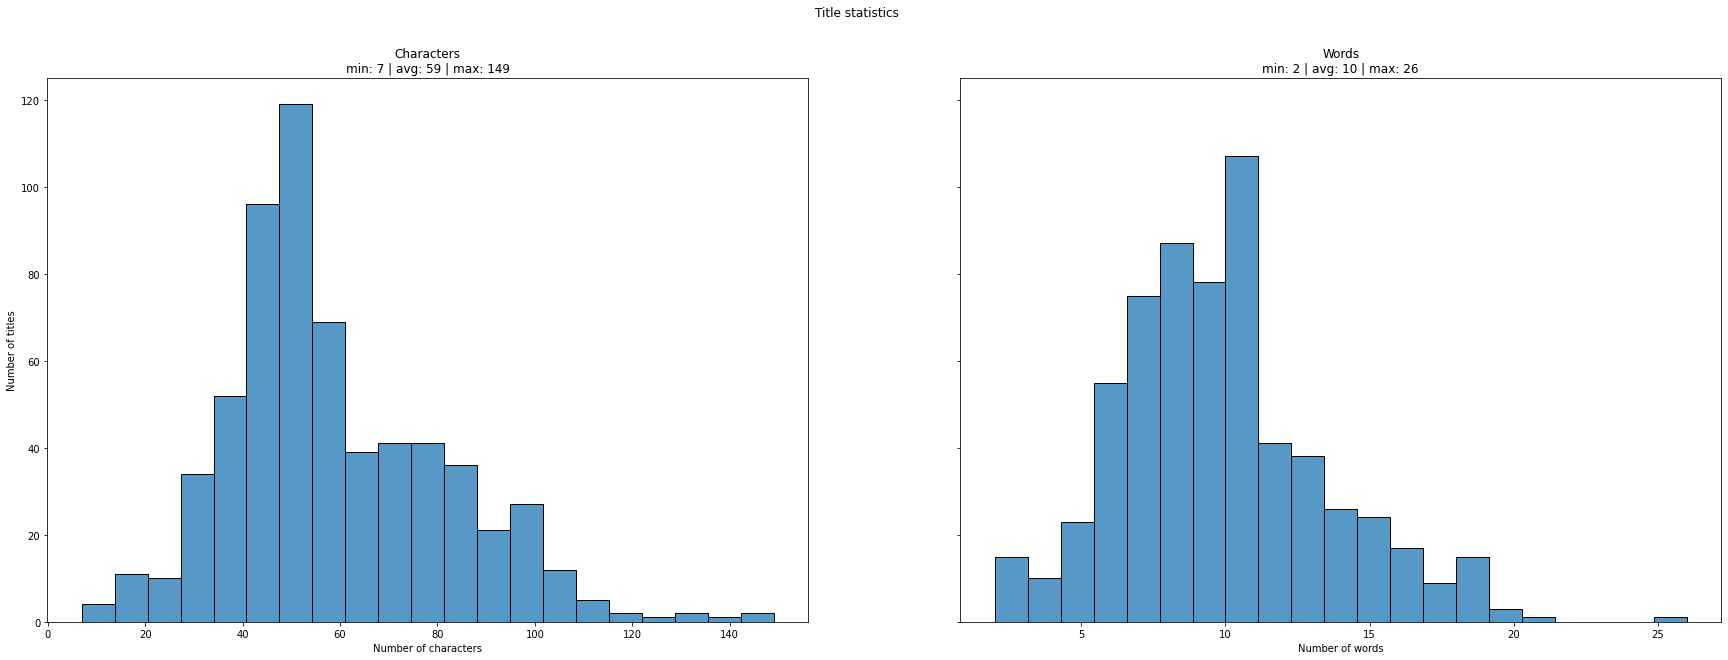

In [13]:
def show_str_statistics(data: pd.DataFrame, column: str) -> None:

    chars_num = data[column].str.len()
    words_num = data[column].apply(lambda x: len(x.split()))

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30, 10), sharey=True)
    fig.suptitle(f"{column.title()} statistics")
    axes = axes.flatten()

    for counts, counts_name, ax in zip([chars_num, words_num], ["characters", "words"], axes):

        title = (
            f"{counts_name.title()}\n" f"min: {counts.min()} | " f"avg: {counts.mean():.0f} | " f"max: {counts.max()}"
        )
        sns.histplot(ax=ax, x=counts)
        ax.set(
            title=title,
            xlabel=f"Number of {counts_name}",
            ylabel="Number of titles",
        )


show_str_statistics(data, "title")


As we can see titles are quite short (both in characters and words metrics).

### 2.1.3. Title topics

It's useful to see what title topics are the most popular. For that [BERTopic](https://github.com/MaartenGr/BERTopic) will be used.

In [14]:
X = data["title"].apply(lambda x: BeautifulSoup(x).text)


In [15]:
# UMAP with the same parameters as created by BERTopic,
# with one addition: random_state
# without it result will be different from run to run
umap_model = UMAP(
    metric="cosine",
    min_dist=0.0,
    n_components=5,
    n_neighbors=15,
    random_state=config.eda.topic_modeling.umap.random_state,
)
model = BERTopic(
    calculate_probabilities=True,
    diversity=0.5,
    embedding_model=config.eda.topic_modeling.bertopic.embedding_model,
    language="english",
    min_topic_size=15,
    n_gram_range=(2, 4),  # I want to see at least bigram, not unigram
    nr_topics="auto",  # topics are automatically merged if similar (> 0.9)
    umap_model=umap_model,
    verbose=True,
)
topics, probabilities = model.fit_transform(X)


Batches: 100%|██████████| 20/20 [00:04<00:00,  4.32it/s]
2022-04-04 18:53:41,556 - BERTopic - Transformed documents to Embeddings
2022-04-04 18:53:50,069 - BERTopic - Reduced dimensionality with UMAP
2022-04-04 18:53:50,127 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-04-04 18:53:53,005 - BERTopic - Reduced number of topics from 7 to 7


In [16]:
model.get_topic_freq()


,Topic,Count
0,-1,301
1,0,143
2,1,73
3,2,42
4,3,28
5,4,23
6,5,15


Topic "-1" contains outliers (that does not belong to any cluster), that means that we have 6 topics.

In [17]:
clusters_df = pd.DataFrame(columns=["Cluster #", "Cluster name", "Topics", "Number of topics"])

for cluster_index, cluster in model.get_topics().items():
    # skipping cluster with outliers
    if cluster_index == -1:
        continue

    # cluster contains data as:
    # [('in china', 0.002428209587760862),
    #  ('first trade', 0.002428209587760862),
    #  ('economic data', 0.002428209587760862)]
    
    # topic with the highest score will be used as cluster's name
    cluster_name = cluster[0][0]
    topics = ", ".join(x[0] for x in cluster)
    number_of_topics = model.get_topic_freq(cluster_index)

    clusters_df.loc[len(clusters_df)] = cluster_index, cluster_name, topics, number_of_topics

clusters_df.style.hide_index()


Cluster #,Cluster name,Topics,Number of topics
0,the fed,"the fed, stocks making the biggest, making the biggest moves, moves premarket, the biggest moves midday, net profit, bull market, outlook is, hedge funds, in 2016",143
1,government shutdown,"government shutdown, new york gov, for retirement, fully vaccinated, coronavirus cases, reform ca leaders propose, release gop, recognizes jerusalem as, recruiters with quick measure, refugees obama nominates",73
2,the brexit,"the brexit, vs yen, euro rises, euro zone, central bank, proof dijsselbloem, range game how, raises key rate to, pm tsipras says, president luxembourg pm",42
3,to open,"to open, wal mart, 2011 surge, prices are overheating, pct in january fliers, pending home sales, pfizer no ifs, pharmacy is, pillpack is battling, prescriptions amazon gives shoppers",28
4,ceo pay,"ceo pay, 10 million, old ceo steps, of firming seen ge, officer standish names raman, organizational shuffle, on protests equal pay, our greatest new threat, ousts its ceo naming, out of his",23
5,oil prices,"oil prices, after khashoggi, saudi aramco, reports us opens, relations not, pushes prices higher saudi, production capacity will return, prices will rise analyst, prices surge on gulf, prepare for an oil",15


Now we can see what are the most popular topics in titles:
- market and government's influence on it
- government, covid, vaccine
- europe and brexit
- what is about to open
- CEOs payments and in contrast unequal payments of workers
- oil and Saudi Arabia 

## 2.2. Url

In [18]:
data.loc[:3, "url"]


0    https://www.cnbc.com/2021/09/29/santolis-wednesday-market-notes-could-septembers-stock-shakeout-...
1    https://www.cnbc.com/2016/06/24/ian-bremmers-take-on-the-early-brexit-winners-and-losers-comment...
2                https://www.cnbc.com/2014/03/25/europes-recovery-depends-on-renzis-italycommentary.html
3             https://www.cnbc.com/2009/04/22/us-moves-closer-to-becoming-a-major-shareholder-in-gm.html
Name: url, dtype: object

Url is represented as a string.

In [19]:
data["url"].str.startswith("https://www.cnbc.com").all()


True

All urls are from "cnbc.com" which does make sense since it's a cnbc dataset :)

## 2.3. Published_at

In [20]:
data.loc[:3, "published_at"]


0    2021-09-29T17:09:39+0000
1    2016-06-24T13:50:48-0400
2    2014-03-25T13:29:45-0400
3    2009-04-22T19:49:03+0000
Name: published_at, dtype: object

"Published_at" column contains dates in datatime format. 

Weaviate expects date format in [RFC 3339](https://weaviate.io/developers/weaviate/current/data-schema/datatypes.html#datatype-date) format. Dates in "published_at" column are in slightly different format: timezone offset should ends with time separated by colon. For example instead of current form:

In [21]:
data.loc[0, "published_at"]


'2021-09-29T17:09:39+0000'

... it should be in form:

In [22]:
data.loc[:0, "published_at"].apply(lambda x: pd.to_datetime(x).isoformat())


0    2021-09-29T17:09:39+00:00
Name: published_at, dtype: object

Otherwise data loading procedure (into Weaviate) might fail without any error, just field (not only with dates) might be empty.

### 2.3.1. Dates statistics

In [23]:
published_dates = pd.to_datetime(data["published_at"], utc=True).to_frame(name="datetime")
published_dates["year"] = published_dates["datetime"].dt.year
published_dates["month"] = published_dates["datetime"].dt.month
published_dates["weekday"] = published_dates["datetime"].dt.weekday

published_dates.iloc[:3]


,datetime,year,month,weekday
0,2021-09-29 17:09:39+00:00,2021,9,2
1,2016-06-24 17:50:48+00:00,2016,6,4
2,2014-03-25 17:29:45+00:00,2014,3,1


In [24]:
print(f"The first article was published in {published_dates.year.min()}.")
print(f"The last  article was published in {published_dates.year.max()}.")


The first article was published in 2006.
The last  article was published in 2021.


In [25]:
print(f"The first article was published on {published_dates.min()['datetime'].strftime('%B %d %Y')}.")
print(f"The last article was published on {published_dates.max()['datetime'].strftime('%B %d %Y')}.")


The first article was published on December 04 2006.
The last article was published on October 18 2021.


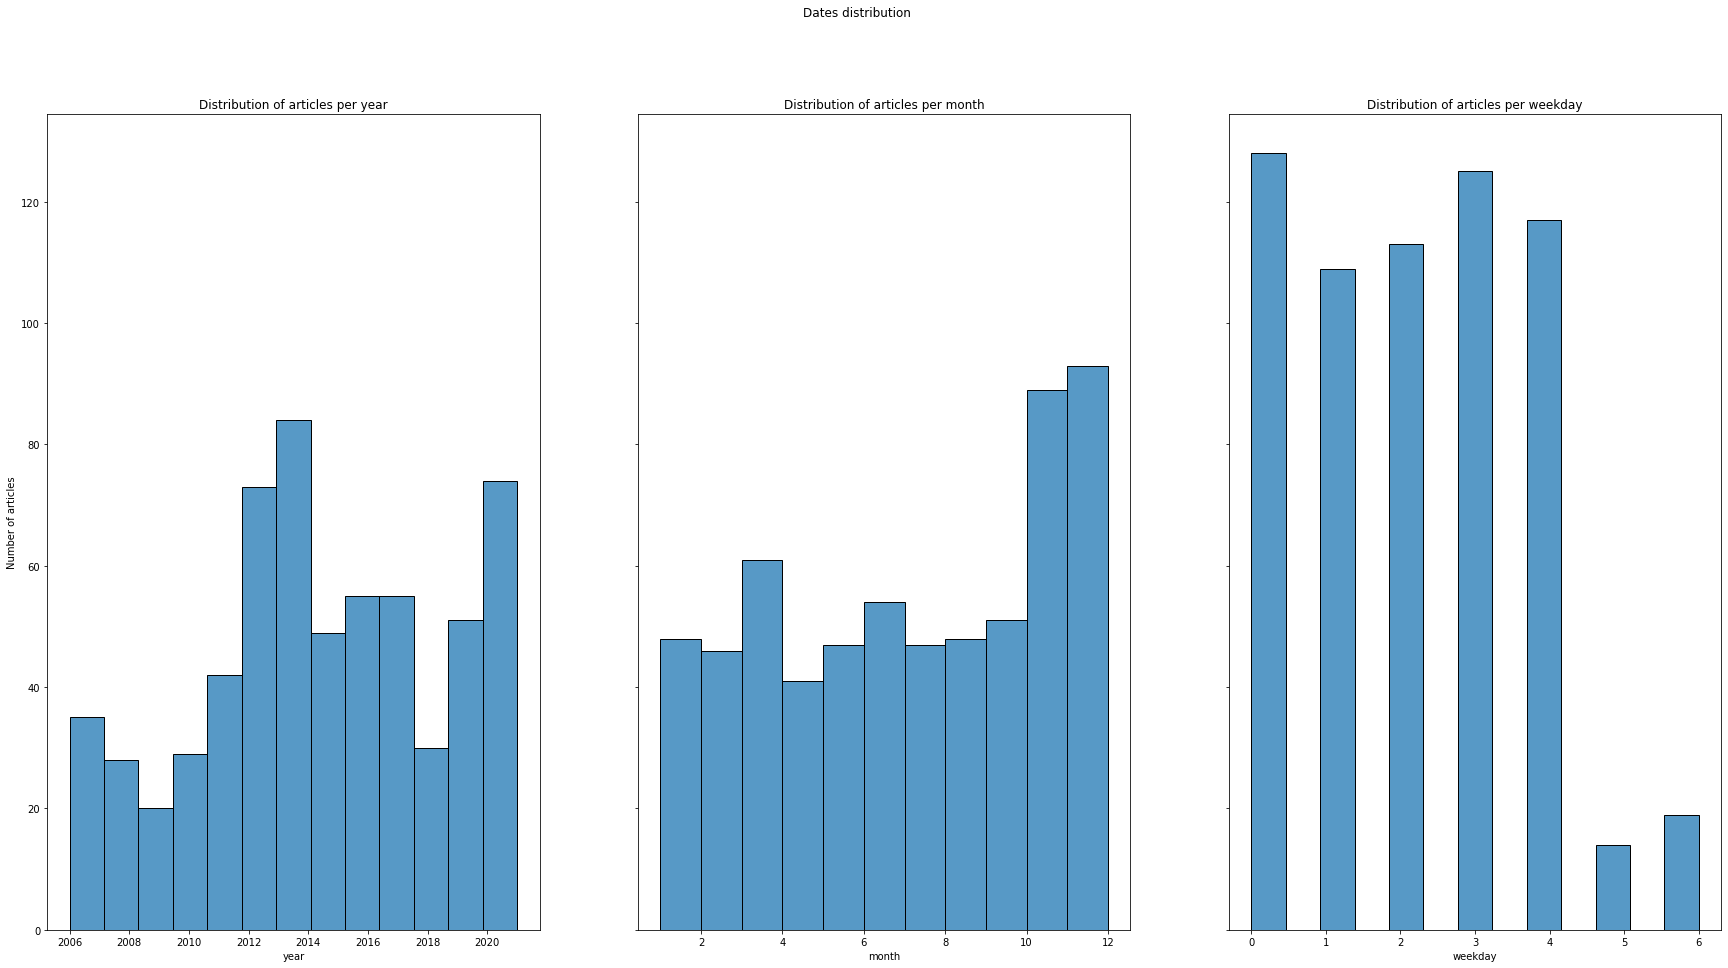

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 15), sharey=True)
fig.suptitle("Dates distribution")

for idx, column_name in enumerate(["year", "month", "weekday"]):
    sns.histplot(ax=axes[idx], x=published_dates[column_name])
    axes[idx].set(title=f"Distribution of articles per {column_name}", ylabel="Number of articles")

plt.show()


Observations:
- **year**: number of articles published per year reached it's peak in 2013
- **month**: more or less even distribution, but in november-december more articles are published (perhaps right before end of the year markets are the most active - more articles to write about)
- **weekday**: significant drop on weekend (which is expected)

## 2.4. Author

In [27]:
data.loc[14:17, "author"]


14                         NaN
15                     Tae Kim
16    Dawn Kopecki,Rich Mendez
17                         NaN
Name: author, dtype: object

Author might by either string containing author name (or multiple with comma separator) or NaN value if author is unknown. As discovered in chapter 1 around 36% of articles have missing author name.

<div class="alert alert-block alert-info"><b>Preprocessing idea</b>: in case of missing value replace it with "Unknown" token.</div>


In [28]:
keywords_count = data["author"].str.count(",")
keywords_count = keywords_count.value_counts()
keywords_count.index = keywords_count.index.map(int) + 1
keywords_count.to_frame().style.bar()


,author
1,379
2,17
3,1


As we can see the majority of all articles has only one author, 17 articles - 2 authors and only one article has 3 authors.

In [29]:
data["author"].describe()


count            397
unique           201
top       Lee Brodie
freq              24
Name: author, dtype: object

Two outcomes:
1. The most popular author is "Lee Brodie" which wrote 24 articles.
2. Number of titles with not missing author name is 397, while number of authors - 201. 

## 2.5. Publisher

In [30]:
data.loc[:3, "publisher"]


0    CNBC
1    CNBC
2    CNBC
3    CNBC
Name: publisher, dtype: object

In [31]:
(data["publisher"] == "CNBC").all()


True

As expected there is only one publisher - CNBC

## 2.6. Short_description

In [32]:
data.loc[:3, "short_description"]


0    This is the daily notebook of Mike Santoli, CNBC's senior markets commentator, with ideas about ...
1    This commentary originally ran on Facebook. Boris Johnson – The former London mayor and grudging...
2    In spring, ambitious reforms began in Italy. Under Matteo Renzi, the ailing economy will either ...
3    The US government is increasingly likely to convert a $13.4 billion loan to General Motors into ...
Name: short_description, dtype: object

In [33]:
data["short_description"].isna().sum()


16

The are only 16 missing short_description values.

In [34]:
print(data["short_description"].str.len().mean().astype(int))
print(data["description"].str.len().mean().astype(int))


1541
3119


On average short_description is around 2x shorter than description.

In [35]:
description_identical_beginning_count = (
    data.dropna(subset=["short_description", "description"])
    .apply(lambda x: x.description.startswith(x.short_description), axis=1)
    .sum()
)

print(
    f"Short description is the begginning of descripion in {description_identical_beginning_count}"
    f"/ {description_identical_beginning_count / len(data) * 100:.1f}% cases"
)


Short description is the begginning of descripion in 544/ 87.0% cases


As we can see short_description is a shortened version of description (hence the name) in 87 % of time. 

<div class="alert alert-block alert-info"><b>Preprocessing idea</b>: In case when short_description is missing but description exists, take beginning of description (maybe the first sentence) and use it as short_description. In case description is missing and short_description exists - use short_description as a description.</div>


## 2.7. Keywords

In [36]:
data.loc[:3, "keywords"]


0    cnbc, Premium, Articles, Investment strategy, Markets, Investing, PRO Home, CNBC Pro, Pro: Santo...
1    Articles, Politics, Europe News, European Central Bank, S&P 500 Index, U.S. Markets, Commentary,...
2    Articles, Business News, Economy, Europe Economy, Employment, Commentary, Politics, source:tagna...
3    cnbc, Articles, General Motors Co, Business News, Transportation, Autos, source:tagname:CNBC US ...
Name: keywords, dtype: object

Keywords is a string with list of keywords and comma separator.

In [37]:
data["keywords"].isna().sum()


0

There are no articles without keywords.

In [38]:
keywords_count = data["keywords"].str.count(",")
keywords_count = keywords_count.value_counts()
keywords_count.index = keywords_count.index.map(int) + 1
print(f"Min number of keywords: {keywords_count.index.min()}")
print(f"Avg number of keywords: {np.mean(keywords_count.index):.0f}")
print(f"Max number of keywords: {keywords_count.index.max()}")
keywords_count.to_frame().iloc[:10].style.bar()


Min number of keywords: 3
Avg number of keywords: 21
Max number of keywords: 60


,keywords
7,74
9,49
8,48
5,48
11,47
6,46
10,40
13,37
12,36
14,28


Minimal number of keywords is 3, maximum - 60 and on average each article contains 21 keywords.

Let's take a look a the article with the maximum number of keywords.

In [39]:
data.loc[data["keywords"].str.count(",") == keywords_count.index.max() - 1, "keywords"].values


array(['cnbc, Articles, Bank of Montreal, Wyoming, Wisconsin, West Virginia, Washington DC, Virginia, Vermont, Utah, Texas, Tennessee, South Dakota, South Carolina, Rhode Island, Pennsylvania, Oregon, Ohio, North Dakota, North Carolina, New York City, New York, New Mexico, New Jersey, New Hampshire, Nevada, Montana, Missouri, Mississippi, Minnesota, Michigan, Massachusetts, Maryland, Maine, Louisiana, Kentucky, Kansas, Iowa, Indiana, Illinois, Idaho, Hawaii, Georgia, Florida, Delaware, Connecticut, Colorado, Chicago, California, Arkansas, Arizona, Alaska, Alabama, North America, United States, Canada, Press Releases, CNBC Information and Policies, CNBC: News Releases, source:tagname:PR Newswire'],
      dtype=object)

Looks like this article contains all US states as keywords.

And here is the most popular set of keywords.

In [40]:
data["keywords"].describe()


count                                                                    625
unique                                                                   581
top       cnbc, Articles, CNBC TV, Fast Money, source:tagname:CNBC US Source
freq                                                                      10
Name: keywords, dtype: object

## 2.8. Header_image

In [41]:
data.loc[:3, "header_image"]


0        https://image.cnbcfm.com/api/v1/image/106949602-1632934577499-FINTECH_ETF_9-29.jpg?v=1632934691
1    https://fm.cnbc.com/applications/cnbc.com/resources/img/editorial/2016/06/24/103742956-RTX2FMUL....
2    https://fm.cnbc.com/applications/cnbc.com/resources/img/editorial/2014/03/24/101520523-480336057...
3                          https://image.cnbcfm.com/api/v1/image/24947979-gm_dealership.jpg?v=1354732729
Name: header_image, dtype: object

In [42]:
image_urls = data["header_image"].apply(lambda x: x.split(".com/")[0])
counter = Counter(image_urls)

counter


Counter({'https://image.cnbcfm': 471,
         'https://fm.cnbc': 12,
         'https://sc.cnbcfm': 142})

Header_image column contains links to the image from article that was used as a header image. There are three different resources from which images can be loaded, but they all are related to CNBC.

## 2.9. Raw_description

In [43]:
data.loc[:3, "raw_description"]


0    <div class="group"><p><em>This is the daily notebook of Mike Santoli, CNBC's senior markets comm...
1                                                                                                    NaN
2                                                                                                    NaN
3    <div class="group"><p>The US government is increasingly likely to convert a $13.4 billion loan t...
Name: raw_description, dtype: object

In [44]:
data["raw_description"].isna().sum()


31

There are 31 missing raw_description values.

Raw_description is a string which supposedly is the same as description only with HTML tags.

Let's check this assumption.

In [45]:
d = data.dropna(subset=["description", "raw_description"])
d["raw_description_stripped"] = d["raw_description"].apply(lambda x: BeautifulSoup(x).text)
description_equal_count = (d["description"] == d["raw_description_stripped"]).sum()
print(
    f"raw_description (without html tags) is the same as description in {description_equal_count} cases"
    f" out of {len(d)} ({description_equal_count / len(d) * 100:.0f}%)."
)


raw_description (without html tags) is the same as description in 136 cases out of 593 (23%).


In [46]:
# this is a partial similarity check
partial_similarity = d.apply(lambda x: ratio(x.description, x.raw_description_stripped), axis=1).mean()
print(f"raw_description (without html tags) and description are similar on average by {partial_similarity * 100:.2f}%.")


raw_description (without html tags) and description are similar on average by 99.95%.


Even raw_description after stripping all html tags is identical to description in only 23% of articles, it's 99.9% similar. That means that only some characters are different like maybe missing space character or some punctuation sign.

<div class="alert alert-block alert-info"><b>Preprocessing idea</b>: In case description is missing and raw_description exists, then raw_description after stripping HTML tags can be used as description.</div>

## 2.10. Description

In [47]:
data.loc[:3, "description"]


0    This is the daily notebook of Mike Santoli, CNBC's senior markets commentator, with ideas about ...
1                                                                                                    NaN
2                                                                                                    NaN
3    The US government is increasingly likely to convert a $13.4 billion loan to General Motors into ...
Name: description, dtype: object

In [48]:
data["description"].isna().sum()


32

There are only 32 articles with missing description.

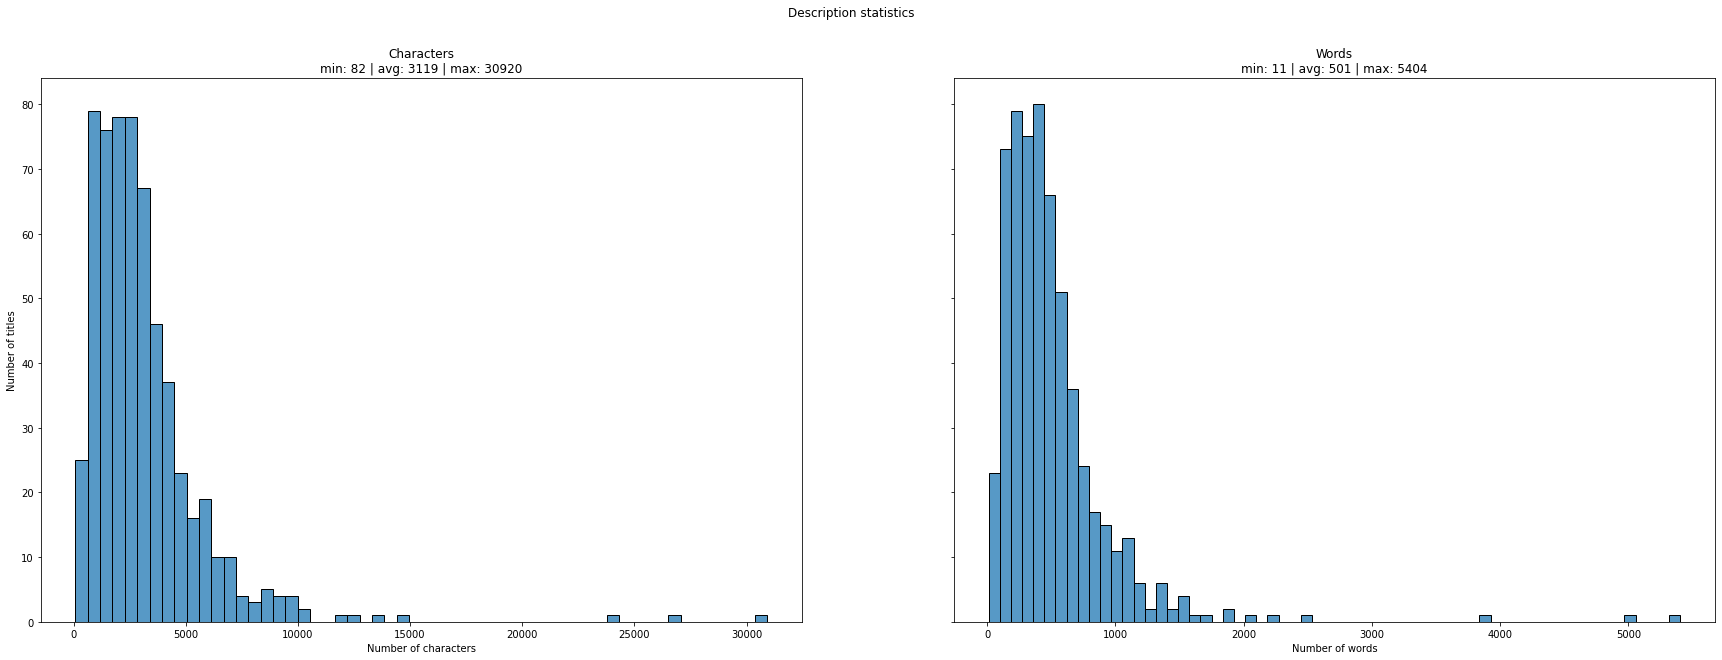

In [49]:
show_str_statistics(data.dropna(subset=["description"]), "description")


As we can see article's description is on average contains ~500 words which is not bad. In the same time there are some articles with short description.

<div class="alert alert-block alert-info"><b>Vectorization idea</b>: not all models can handle a string with this length. Some models with a string of length that exceeds maximum expected length might fail or automatically truncate input. In both cases it might be beneficial to split long texts into smaller parts and vectorize them separately.</div>

<div class="alert alert-block alert-info"><b>Preprocessing idea</b>: In case description is missing it can be replaced by raw_description after stripping html tags and if raw_description is missing - by short_description. In addition it might be a good idea to drop articles with low number of words (maybe less then 20?).</div>

## 2.11. Scraped_at

In [50]:
data.loc[:3, "scraped_at"]


0    2021-10-30 14:11:23.709372
1    2021-10-30 14:11:23.820139
2    2021-10-30 14:11:23.854710
3    2021-10-30 14:11:24.261143
Name: scraped_at, dtype: object

In [51]:
scraped_dates = pd.to_datetime(data["scraped_at"])
scraped_dates = scraped_dates.dt.strftime("%Y-%m-%d")
scraped_dates.duplicated(keep=False).all()


True

As we can see all articles were scraped at the same date (year-month-day).

# 3. List of preprocessing recommendations

Steps for preprocessing:
1. **title**: get rid of special characters, strip empty chars in the beginning/end of the text
2. **published_at**: convert to RFC 3339 format
3. **author**: if author is missing replace with "Unknown" token
4. **short_description**: if missing, take beginning of the description (the first sentence or first 1500 chars as it's an average len of short_description).
5. **description**: if missing, take raw_description (if exist) and strip HTML tags; if raw_description is also missing - take short_description (if exist). If all 3 descriptions are missing - drop that article. 